In [2]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from keras import layers
from keras import models
from keras.layers import PReLU
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import h5py
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [4]:
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()


In [6]:
shape = train_data.shape
img_rows = shape[1]
img_cols = shape[2]
channels = shape[3]

print("Розмір тренувального датасету:", len(train_data))
print("Розмір тестового датасету:", len(test_data))
print("Значення міток: від", min(train_labels), "до", max(train_labels))
print("Перший елемент тренувального датасету:", train_data[0])
print("Мітки тренувального датасету:", train_labels)


Розмір тренувального датасету: 50000
Розмір тестового датасету: 10000
Значення міток: від [0] до [9]
Перший елемент тренувального датасету: [[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
Мітки тренувального датасету: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


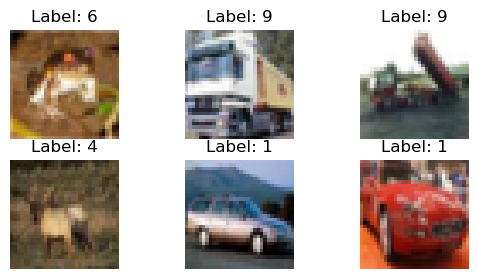

In [8]:
num_samples = 6

for i in range(num_samples):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i])
    plt.title(f"Label: {train_labels[i][0]}")
    plt.axis('off')

plt.show()


In [10]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
vgg16_base.trainable = False

vgg16_base.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [12]:
model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(64, activation="PReLU"),
    layers.Dense(10, activation="softmax")
])
                                                  
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131200    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 14846538 (56.64 MB)
Trainable params: 131850 (515.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
def resize_image(image, target_size=(64, 64)):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image)
    image = image.resize(target_size)
    return np.array(image)

resized_train_data = np.array([resize_image(img) for img in train_data])
resized_test_data = np.array([resize_image(img) for img in test_data])

resized_train_data = resized_train_data / 255
resized_test_data = resized_test_data / 255

print(resized_train_data.shape)
print(resized_test_data.shape)


(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [32]:
def history_visual(history):    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    val_acc_values = history_dict['val_accuracy']
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [37]:
history = model.fit(
    resized_train_data,
    train_labels, 
    epochs=10,
    batch_size=256,  
    validation_data=(resized_test_data, test_labels)
)

Epoch 1/10


196/196 [==============================] - 919s 5s/step - loss: 1.2193 - accuracy: 0.5855 - val_loss: 1.0293 - val_accuracy: 0.6448
Epoch 2/10
196/196 [==============================] - 890s 5s/step - loss: 0.9238 - accuracy: 0.6860 - val_loss: 0.9377 - val_accuracy: 0.6787
Epoch 3/10
196/196 [==============================] - 1082s 6s/step - loss: 0.8488 - accuracy: 0.7093 - val_loss: 0.8808 - val_accuracy: 0.7012
Epoch 4/10
196/196 [==============================] - 973s 5s/step - loss: 0.8045 - accuracy: 0.7235 - val_loss: 0.8624 - val_accuracy: 0.7063
Epoch 5/10
196/196 [==============================] - 988s 5s/step - loss: 0.7669 - accuracy: 0.7361 - val_loss: 0.8592 - val_accuracy: 0.7023
Epoch 6/10
196/196 [==============================] - 1070s 5s/step - loss: 0.7409 - accuracy: 0.7443 - val_loss: 0.8626 - val_accuracy: 0.7031
Epoch 7/10
196/196 [==============================] - 1123s 6s/step - loss: 0.7108 - accuracy: 0.7561 - val_loss: 0.8646 - val_accuracy: 0

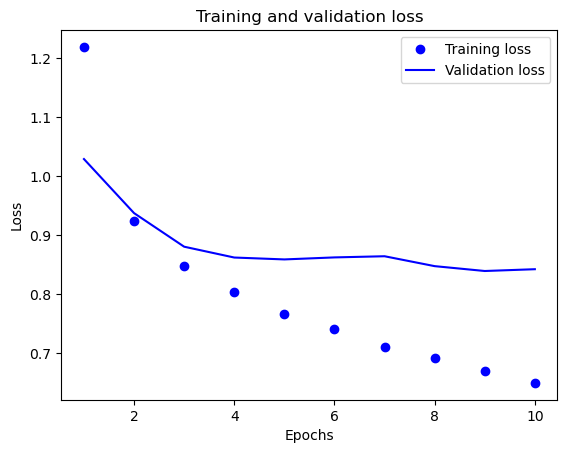

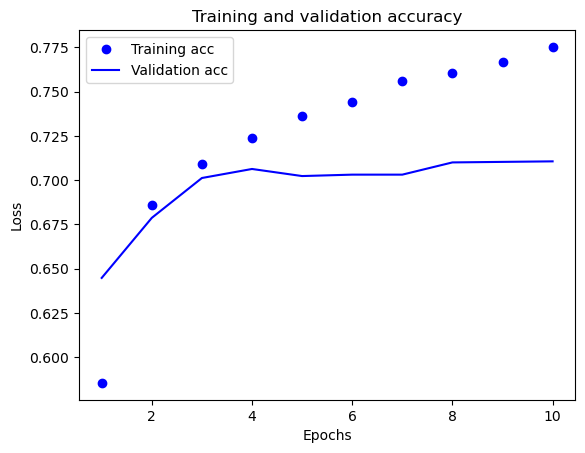

In [39]:
history_visual(history)